In [2055]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot

from datetime import date

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.api import VAR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import math

import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

## 1.1. Data collection

In [2056]:
file_path = 'data/vietnam_macro_economic_by_month.csv'
data = pd.read_csv(file_path)
data.head()

,Thời gian,FDI,FDI đăng kí (lũy kế năm),FDI giải ngân (lũy kế năm),Thương mại (lũy kế năm),Xuất khẩu (lũy kế năm),Nhập khẩu (lũy kế năm),Cung tiền & tín dụng,Tăng trưởng tín dụng,Nông nghiệp,...,Chi thường xuyên,Chỉ số giá,Lạm phát cơ bản,Lạm phát,Thực phẩm,Nhà ở và VLXD,Y tế,Vận tải,Chỉ số PMI,Tăng trưởng GDP thực tế
0,-,-,% YoY,% YoY,-,% YoY,% YoY,-,% YoY,% YoY,...,% YoY,-,% YoY,% YoY,% YoY,% YoY,% YoY,% YoY,-,% YoY
1,T1 2017,-,19,6.3,-,6,3.2,-,19.5,17.7,...,NaN,-,1.9,5.2,2.4,3.5,79.4,5,51.9,5.2
2,T2 2017,-,21.5,3.3,-,16.5,23.5,-,19.6,17.5,...,NaN,-,1.5,5,-0.3,4.8,79.8,10,54.2,5.2
3,T3 2017,-,91.5,3.4,-,15.7,25.4,-,21.6,17.9,...,NaN,-,1.6,4.7,-0.9,5.3,48.7,14.6,54.6,5.2
4,T4 2017,-,53.9,3.2,-,17.4,24.8,-,20.6,17.8,...,NaN,-,1.5,4.3,-1.7,4.3,63.6,11.1,54.1,6.4


## 1.2. Data Preprocessing

### 1.2.1. Clean columns

In [2057]:
data.columns

Index(['Thời gian', 'FDI', 'FDI đăng kí (lũy kế năm)',
       'FDI giải ngân (lũy kế năm)', 'Thương mại (lũy kế năm)',
       'Xuất khẩu  (lũy kế năm)', 'Nhập khẩu  (lũy kế năm)',
       'Cung tiền & tín dụng', 'Tăng trưởng tín dụng', 'Nông nghiệp',
       'Thương mại', 'Công nghiệp', 'Xây dựng', 'Cung tiền M2', 'Tài khóa',
       'Tổng thu', 'Nội địa', 'Tổng chi', 'Chi đầu tư phát triển',
       'Chi thường xuyên', 'Chỉ số giá', 'Lạm phát cơ bản', 'Lạm phát',
       'Thực phẩm', 'Nhà ở và VLXD', 'Y tế', 'Vận tải', 'Chỉ số PMI',
       'Tăng trưởng GDP thực tế'],
      dtype='object')

In [2058]:
columns = ['Thoi_gian', 'FDI', 'FDI_dang_ki',
       'FDI_giai_ngan', 'Thuong_mai_luy_ke_nam',
       'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam',
       'Cung_tien_va_tin_dung', 'Tang_truong_tin_dung', 'Nong_nghiep',
       'Thuong_mai', 'Cong_nghiep', 'Xay_dung', 'Cung_tien_M2', 'Tai_khoa',
       'Tong_thu', 'Noi_dia', 'Tong_chi', 'Chi_dau_tu_phat_trien',
       'Chi_thuong_xuyen', 'Chi_so_gia', 'Lam_phat_co_ban', 'Lam_phat',
       'Thuc_pham', 'Nha_o_va_VLXD', 'Y_te', 'Van_tai', 'Chi_so_PMI',
       'Tang_truong_GDP_thuc_te']

data.columns = columns

print("Column names after cleaning:", data.columns)

Column names after cleaning: Index(['Thoi_gian', 'FDI', 'FDI_dang_ki', 'FDI_giai_ngan',
       'Thuong_mai_luy_ke_nam', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam',
       'Cung_tien_va_tin_dung', 'Tang_truong_tin_dung', 'Nong_nghiep',
       'Thuong_mai', 'Cong_nghiep', 'Xay_dung', 'Cung_tien_M2', 'Tai_khoa',
       'Tong_thu', 'Noi_dia', 'Tong_chi', 'Chi_dau_tu_phat_trien',
       'Chi_thuong_xuyen', 'Chi_so_gia', 'Lam_phat_co_ban', 'Lam_phat',
       'Thuc_pham', 'Nha_o_va_VLXD', 'Y_te', 'Van_tai', 'Chi_so_PMI',
       'Tang_truong_GDP_thuc_te'],
      dtype='object')


In [2059]:
selected_columns = ['Thoi_gian', 'FDI_dang_ki', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam', 'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat', 'Tang_truong_GDP_thuc_te']
data = data[selected_columns]

# Drop hàng thứ 2 (hàng chứa thông tin về đơn vị)
data = data.drop(0)

data.head()
data.shape

(84, 8)

### 1.2.2. Convert date format

In [2060]:
def convert_date(date_str):
    month_map = {
        'T1': '01', 'T2': '02', 'T3': '03', 'T4': '04', 'T5': '05',
        'T6': '06', 'T7': '07', 'T8': '08', 'T9': '09', 'T10': '10',
        'T11': '11', 'T12': '12'
    }
    month, year = date_str.split()
    month = month_map[month]
    return pd.to_datetime(f'{year}-{month}-01')


time_column = 'Thoi_gian'
data[time_column] = data[time_column].apply(convert_date)

data[time_column] = pd.to_datetime(data[time_column])
data.set_index(time_column, inplace=True)

data.head()

,FDI_dang_ki,Xuat_khau_luy_ke_nam,Nhap_khau_luy_ke_nam,Tang_truong_tin_dung,Cung_tien_M2,Lam_phat,Tang_truong_GDP_thuc_te
Thoi_gian,,,,,,,
2017-01-01,19,6,3.2,19.5,19.7,5.2,5.2
2017-02-01,21.5,16.5,23.5,19.6,18.1,5,5.2
2017-03-01,91.5,15.7,25.4,21.6,17.7,4.7,5.2
2017-04-01,53.9,17.4,24.8,20.6,17,4.3,6.4
2017-05-01,19.4,19,25.3,22,16.2,3.2,6.4


### 1.2.3. Handle missing value

In [2061]:
data.isna().sum()

FDI_dang_ki                0
Xuat_khau_luy_ke_nam       5
Nhap_khau_luy_ke_nam       2
Tang_truong_tin_dung       0
Cung_tien_M2               0
Lam_phat                   0
Tang_truong_GDP_thuc_te    0
dtype: int64

In [2062]:
xuat_khau = 'Xuat_khau_luy_ke_nam'
nhap_khau = 'Nhap_khau_luy_ke_nam'

# xử lí những giá trị null trong cột xuất khẩu và nhập khẩu bằng nội suy tuyến tính
data[xuat_khau] = data[xuat_khau].replace({None: np.nan, '': np.nan})
data[nhap_khau] = data[nhap_khau].replace({None: np.nan, '': np.nan})

# Convert columns to numeric
data[xuat_khau] = pd.to_numeric(data[xuat_khau], errors='coerce')
data[nhap_khau] = pd.to_numeric(data[nhap_khau], errors='coerce')

data[xuat_khau] = data[xuat_khau].interpolate(method='linear')
data[nhap_khau] = data[nhap_khau].interpolate(method='linear')

missing_values = data.isna().sum()
missing_values[missing_values > 0]

data = data.astype(float)

### 1.2.2. Stationarity

#### Plot time series and check for trends or seasonality with mean and varience

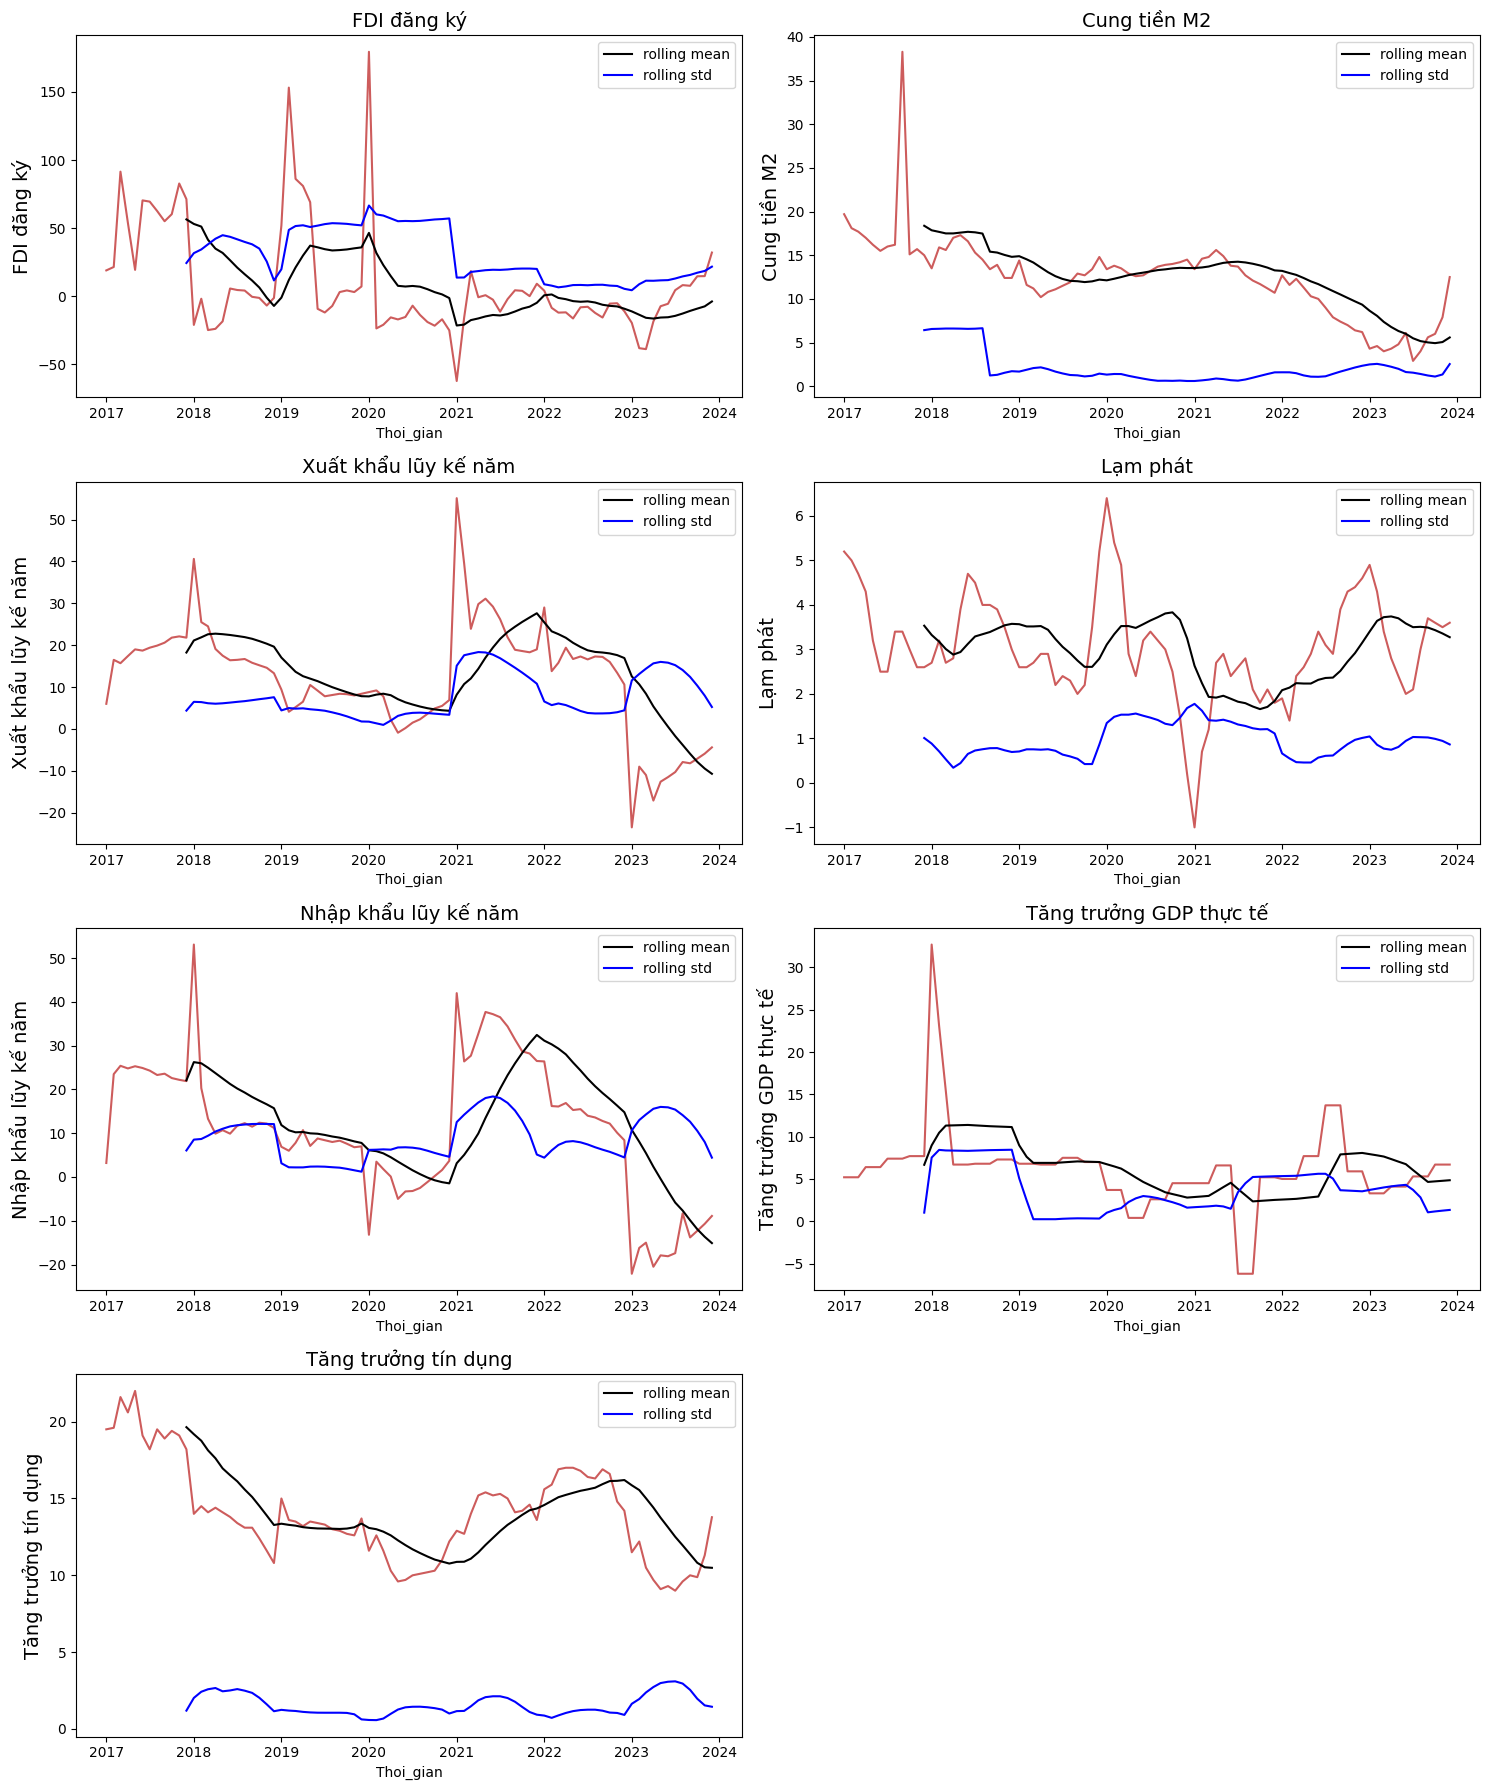

In [2063]:
def plot_time_series(ax, x, y, rolling_window, title, ylabel, color='indianred'):
    sns.lineplot(x=x, y=y, ax=ax, color=color)
    sns.lineplot(x=x, y=y.rolling(rolling_window).mean(), ax=ax, color='black', label='rolling mean')
    sns.lineplot(x=x, y=y.rolling(rolling_window).std(), ax=ax, color='blue', label='rolling std')
    ax.set_title(title, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

rolling_window = 12  # Đặt giá trị phù hợp với dữ liệu (12 tháng = 1 năm)
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 18))

plot_time_series(ax[0, 0], data.index, data.FDI_dang_ki, rolling_window, 'FDI đăng ký', 'FDI đăng ký')
plot_time_series(ax[1, 0], data.index, data.Xuat_khau_luy_ke_nam, rolling_window, 'Xuất khẩu lũy kế năm', 'Xuất khẩu lũy kế năm')
plot_time_series(ax[2, 0], data.index, data.Nhap_khau_luy_ke_nam, rolling_window, 'Nhập khẩu lũy kế năm', 'Nhập khẩu lũy kế năm')
plot_time_series(ax[3, 0], data.index, data.Tang_truong_tin_dung, rolling_window, 'Tăng trưởng tín dụng', 'Tăng trưởng tín dụng')
plot_time_series(ax[0, 1], data.index, data.Cung_tien_M2, rolling_window, 'Cung tiền M2', 'Cung tiền M2')
plot_time_series(ax[1, 1], data.index, data.Lam_phat, rolling_window, 'Lạm phát', 'Lạm phát')
plot_time_series(ax[2, 1], data.index, data.Tang_truong_GDP_thuc_te, rolling_window, 'Tăng trưởng GDP thực tế', 'Tăng trưởng GDP thực tế')

f.delaxes(ax[3, 1])  # Remove empty plot if exists

plt.tight_layout()
plt.show()


Chúng ta có thể thấy rằng tất cả các feature đều có phương sai trung bình và  hằng số thay đổi theo thời gian.  
Nếu như quan sát bằng những biểu đồ này, không cái nào trong số này có tính dừng.   

#### Augmented Dickey-Fuller (ADF) test

Forest Green: Strong evidence that the series is stationary (ADF statistic is less than the 1% critical value).     
Gold: Moderate evidence that the series is stationary (ADF statistic is less than the 5% critical value).   
Orange: Weak evidence that the series is stationary (ADF statistic is less than the 10% critical value).    
Indian Red: Evidence that the series is non-stationary. 

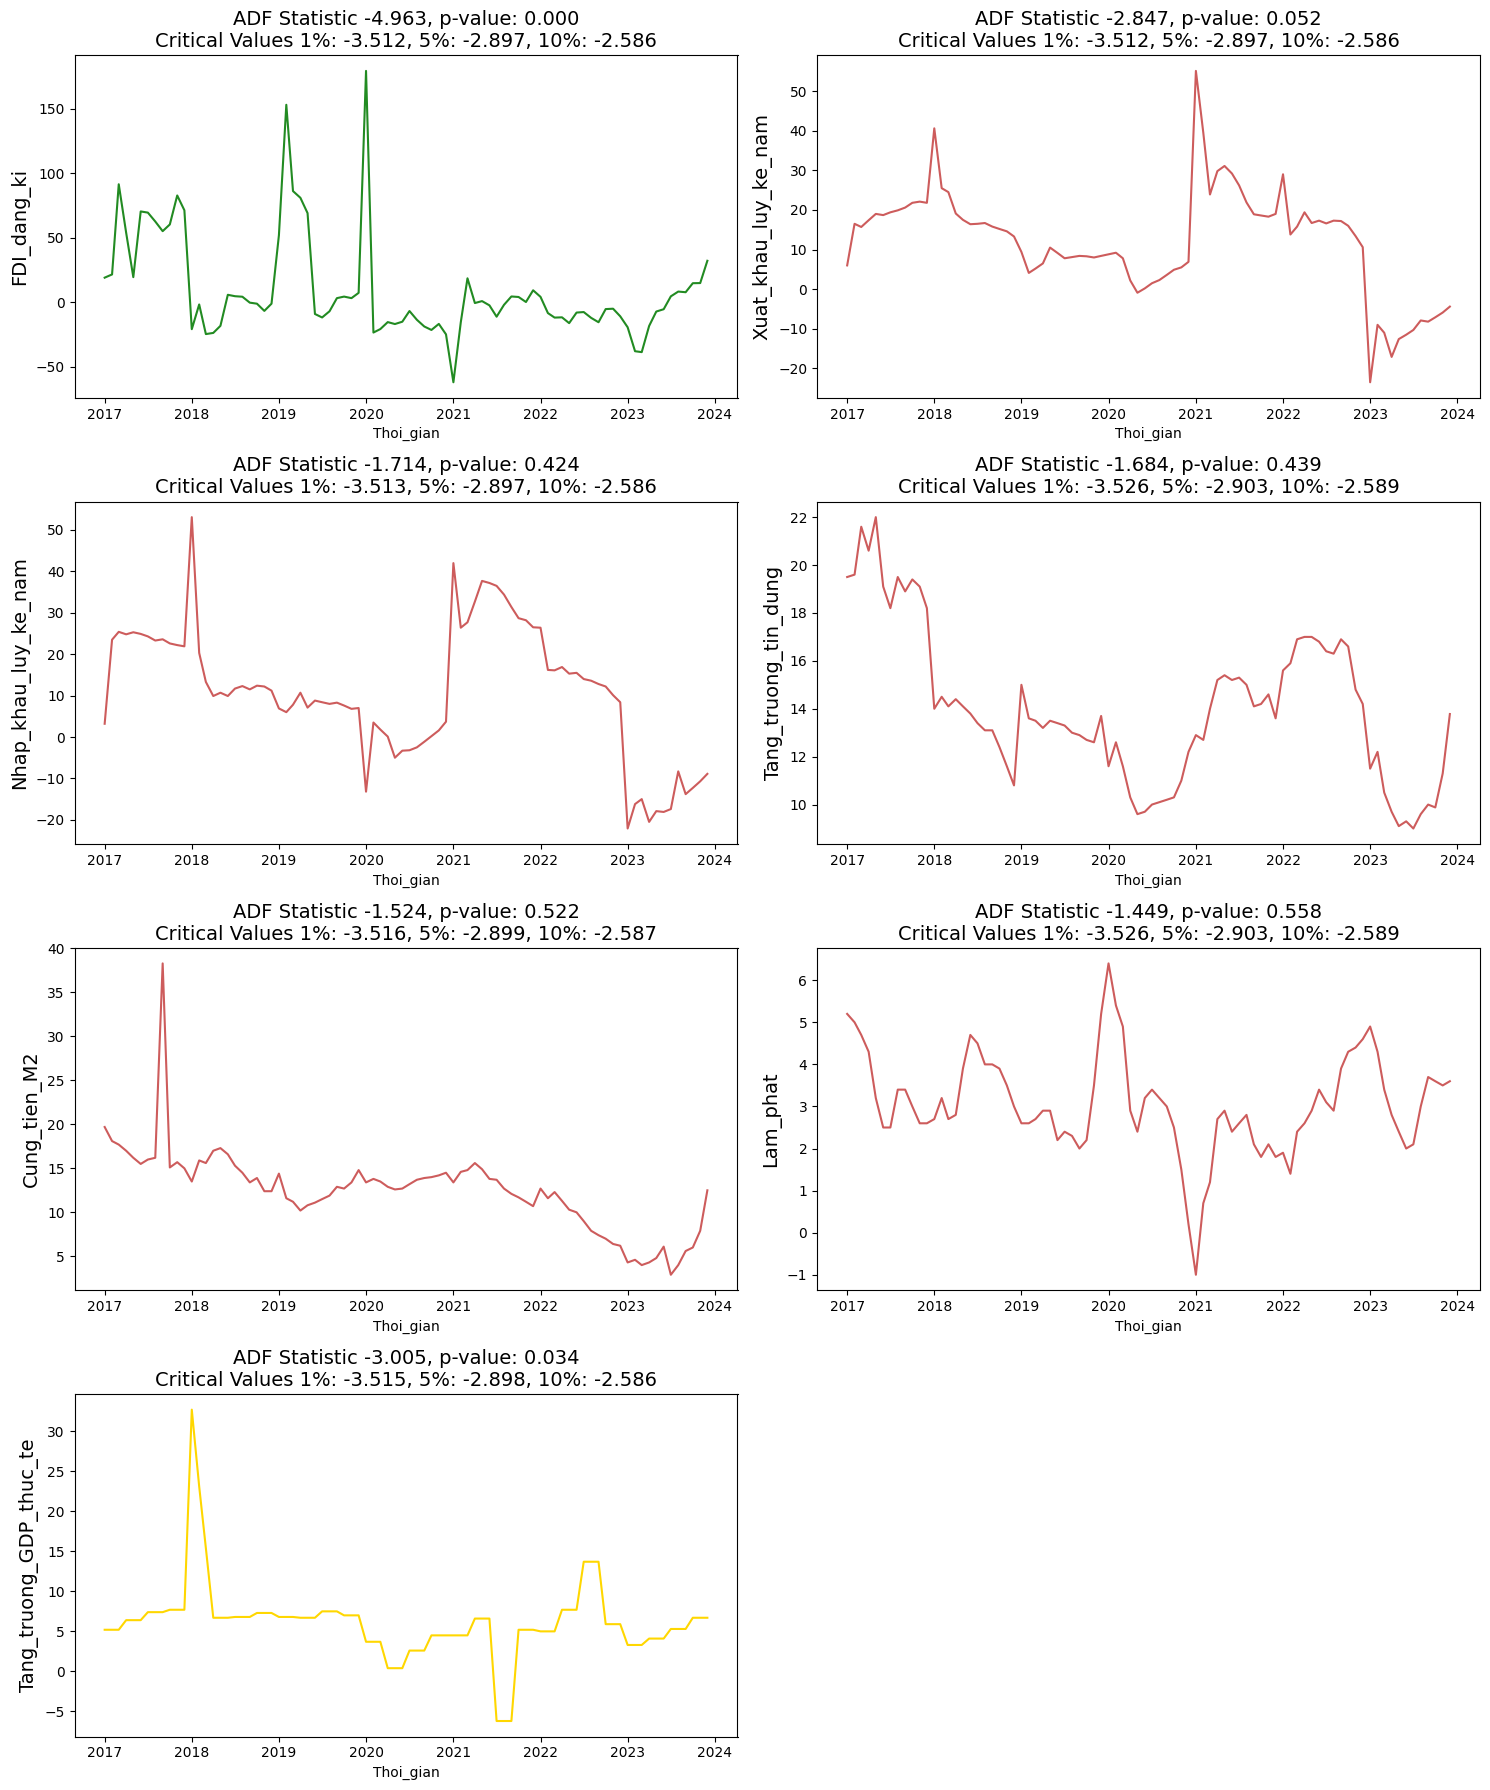

In [2064]:
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series) # check adf
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & (adf_stat < crit_val_1):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'

    sns.lineplot(x=series.index, y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

f, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 18))

columns = ['FDI_dang_ki', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam', 
           'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat', 'Tang_truong_GDP_thuc_te']

for i, column in enumerate(columns):
    row = i // 2
    col = i % 2
    visualize_adfuller_results(data[column], column, ax[row, col])

# Remove empty subplots if has
if len(columns) % 2 != 0:
    f.delaxes(ax[len(columns) // 2, 1])

plt.tight_layout()
plt.show()

### 1.2.3. Transformation

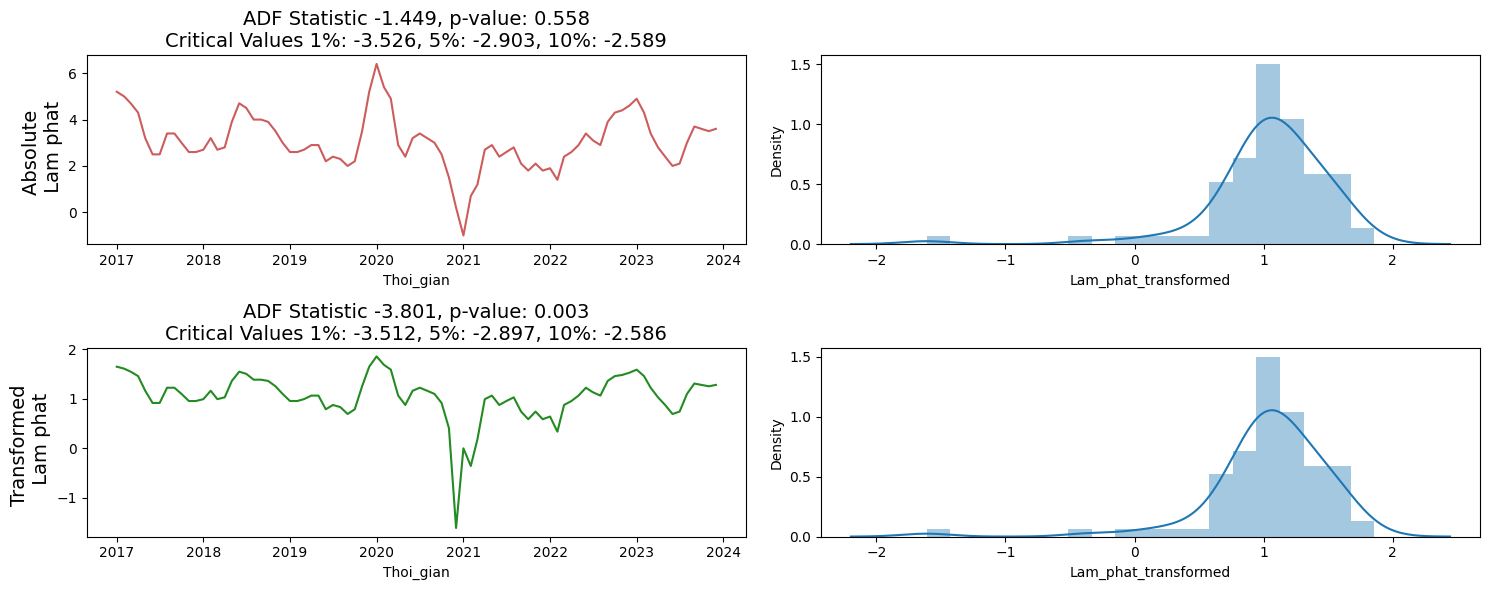

In [2065]:
# chuyển đổi cột Lam_phat bằng cách lấy logarit tự nhiên của các giá trị tuyệt đối của nó.
data['Lam_phat_transformed'] = np.log(abs(data.Lam_phat))
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
visualize_adfuller_results(data.Lam_phat, 'Absolute \n Lam phat', ax[0, 0])
sns.distplot(data.Lam_phat_transformed, ax=ax[0, 1])

visualize_adfuller_results(data.Lam_phat_transformed, 'Transformed \n Lam phat', ax[1, 0])
sns.distplot(data.Lam_phat_transformed, ax=ax[1, 1])

plt.tight_layout()
plt.show()

### 1.2.4. Differencing

In [2066]:
# # First Order Differencing
# ts_diff = np.diff(data.Tang_truong_GDP_thuc_te)
# data['Tang_truong_GDP_thuc_te_diff_1'] = np.append([0], ts_diff)

# # Second Order Differencing
# ts_diff = np.diff(data.Tang_truong_GDP_thuc_te)
# data['Tang_truong_GDP_thuc_te_diff_2'] = np.append([0], ts_diff)

# f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))

# visualize_adfuller_results(data.Tang_truong_GDP_thuc_te_diff_1, 'Differenced (1. Order) \n Tang truong GDP thuc te', ax[0])
# visualize_adfuller_results(data.Tang_truong_GDP_thuc_te_diff_2, 'Differenced (2. Order) \n Tang truong GDP thuc te', ax[1])
# plt.tight_layout()
# plt.show()

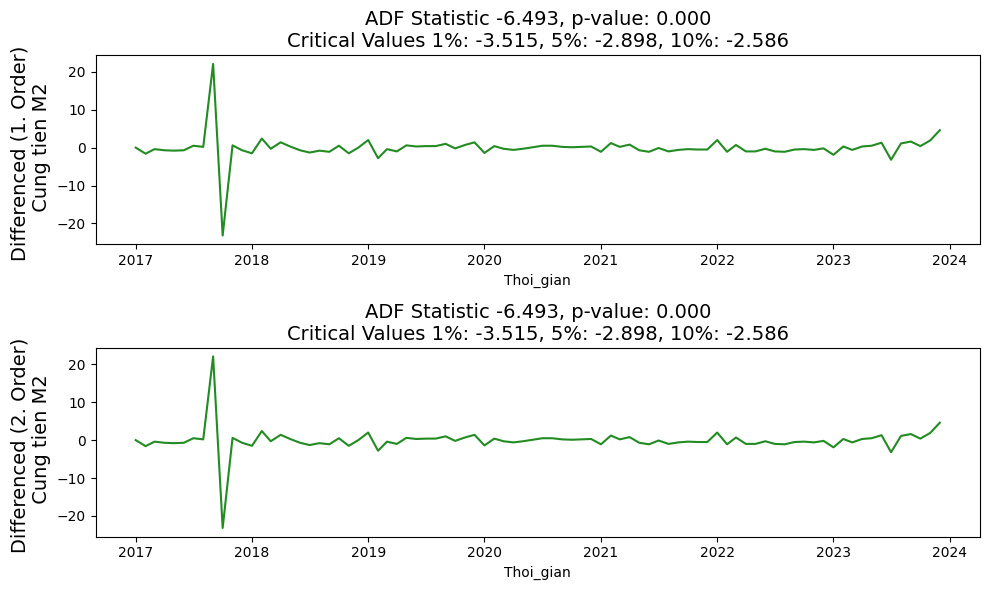

In [2067]:
# First Order Differencing
ts_diff = np.diff(data.Cung_tien_M2)
data['Cung_tien_M2_diff_1'] = np.append([0], ts_diff)

# Second Order Differencing
ts_diff = np.diff(data.Cung_tien_M2)
data['Cung_tien_M2_diff_2'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

visualize_adfuller_results(data.Cung_tien_M2_diff_1, 'Differenced (1. Order) \n Cung tien M2', ax[0])
visualize_adfuller_results(data.Cung_tien_M2_diff_2, 'Differenced (2. Order) \n Cung tien M2', ax[1])
plt.tight_layout()
plt.show()

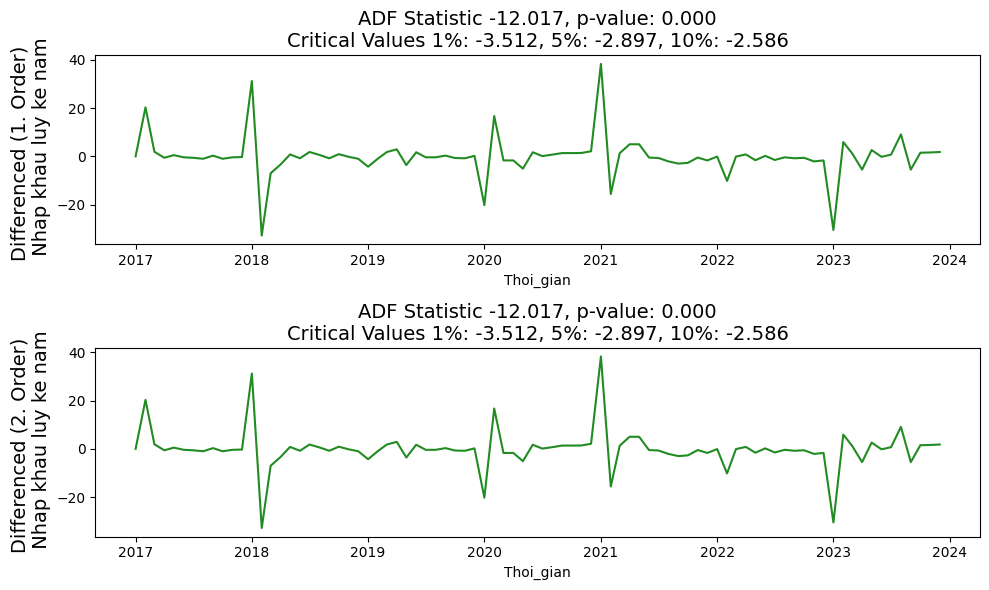

In [2068]:
# First Order Differencing
ts_diff = np.diff(data.Nhap_khau_luy_ke_nam)
data['Nhap_khau_luy_ke_nam_diff_1'] = np.append([0], ts_diff)

# Second Order Differencing
ts_diff = np.diff(data.Nhap_khau_luy_ke_nam)
data['Nhap_khau_luy_ke_nam_diff_2'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

visualize_adfuller_results(data.Nhap_khau_luy_ke_nam_diff_1, 'Differenced (1. Order) \n Nhap khau luy ke nam', ax[0])
visualize_adfuller_results(data.Nhap_khau_luy_ke_nam_diff_2, 'Differenced (2. Order) \n Nhap khau luy ke nam', ax[1])
plt.tight_layout()
plt.show()

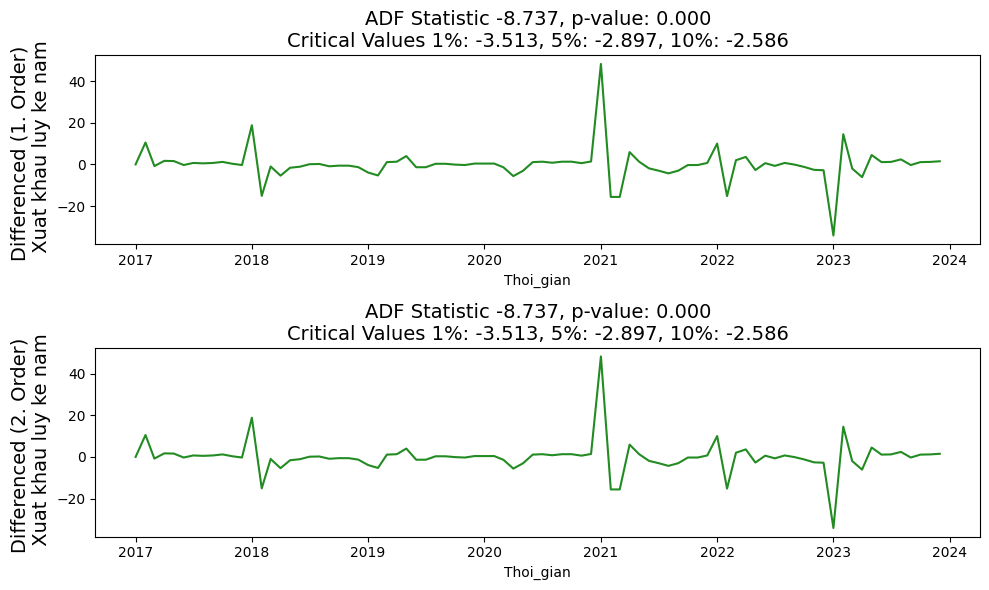

In [2069]:
# First Order Differencing
ts_diff = np.diff(data.Xuat_khau_luy_ke_nam)
data['Xuat_khau_luy_ke_nam_diff_1'] = np.append([0], ts_diff)

# Second Order Differencing
ts_diff = np.diff(data.Xuat_khau_luy_ke_nam)
data['Xuat_khau_luy_ke_nam_diff_2'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

visualize_adfuller_results(data.Xuat_khau_luy_ke_nam_diff_1, 'Differenced (1. Order) \n Xuat khau luy ke nam', ax[0])
visualize_adfuller_results(data.Xuat_khau_luy_ke_nam_diff_2, 'Differenced (2. Order) \n Xuat khau luy ke nam', ax[1])
plt.tight_layout()
plt.show()

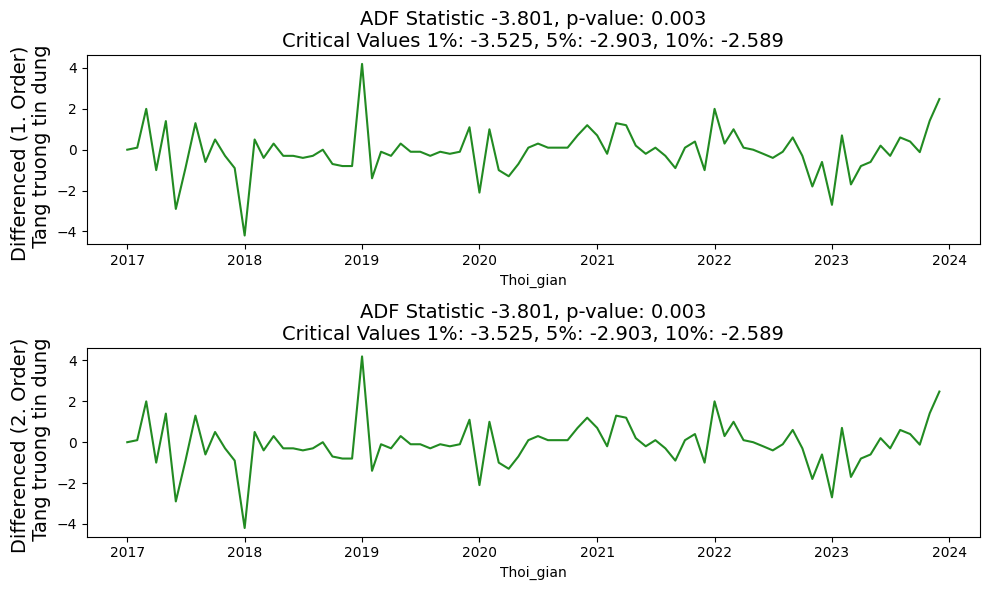

In [2070]:
# First Order Differencing
ts_diff = np.diff(data.Tang_truong_tin_dung)
data['Tang_truong_tin_dung_diff_1'] = np.append([0], ts_diff)

# Second Order Differencing
ts_diff = np.diff(data.Tang_truong_tin_dung)
data['Tang_truong_tin_dung_diff_2'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

visualize_adfuller_results(data.Tang_truong_tin_dung_diff_1, 'Differenced (1. Order) \n Tang truong tin dung', ax[0])
visualize_adfuller_results(data.Tang_truong_tin_dung_diff_2, 'Differenced (2. Order) \n Tang truong tin dung', ax[1])
plt.tight_layout()
plt.show()

In [2071]:
data.Cung_tien_M2.equals(data.Cung_tien_M2_diff_1.cumsum() + data.Cung_tien_M2.iloc[0])
data.Nhap_khau_luy_ke_nam.equals(data.Nhap_khau_luy_ke_nam_diff_1.cumsum() + data.Nhap_khau_luy_ke_nam.iloc[0])
data.Xuat_khau_luy_ke_nam.equals(data.Xuat_khau_luy_ke_nam_diff_1.cumsum() + data.Xuat_khau_luy_ke_nam.iloc[0])
data.Tang_truong_tin_dung.equals(data.Tang_truong_tin_dung_diff_1.cumsum() + data.Tang_truong_tin_dung.iloc[0])

True

In [2072]:
data.columns

Index(['FDI_dang_ki', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam',
       'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat',
       'Tang_truong_GDP_thuc_te', 'Lam_phat_transformed',
       'Cung_tien_M2_diff_1', 'Cung_tien_M2_diff_2',
       'Nhap_khau_luy_ke_nam_diff_1', 'Nhap_khau_luy_ke_nam_diff_2',
       'Xuat_khau_luy_ke_nam_diff_1', 'Xuat_khau_luy_ke_nam_diff_2',
       'Tang_truong_tin_dung_diff_1', 'Tang_truong_tin_dung_diff_2'],
      dtype='object')

## 1.3. Feature Engineering

### 1.3.1. Decomposition

##### The characteristics of a time series are

1. Trend and Level
2. Seasonality
3. Random / Noise   
We can use the function seasonal_decompose() from the statsmodels library.

Additive: y(t)=Level+Trend+Seasonality+Noise    
Multiplicative: y(t)=Level∗Trend∗Seasonality∗Noise  

In [2073]:
data.columns

Index(['FDI_dang_ki', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam',
       'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat',
       'Tang_truong_GDP_thuc_te', 'Lam_phat_transformed',
       'Cung_tien_M2_diff_1', 'Cung_tien_M2_diff_2',
       'Nhap_khau_luy_ke_nam_diff_1', 'Nhap_khau_luy_ke_nam_diff_2',
       'Xuat_khau_luy_ke_nam_diff_1', 'Xuat_khau_luy_ke_nam_diff_2',
       'Tang_truong_tin_dung_diff_1', 'Tang_truong_tin_dung_diff_2'],
      dtype='object')

In [2074]:
decompose_cols =  ['Tang_truong_GDP_thuc_te', 'FDI_dang_ki', 'Xuat_khau_luy_ke_nam_diff_1', 'Nhap_khau_luy_ke_nam_diff_1',
       'Tang_truong_tin_dung_diff_1', 'Cung_tien_M2_diff_1', 'Lam_phat_transformed']

for col in decompose_cols:
    decomp = seasonal_decompose(data[col], period=12, model='additive', extrapolate_trend='freq')
    data[f"{col}_trend"] = decomp.trend
    data[f"{col}_seasonal"] = decomp.seasonal

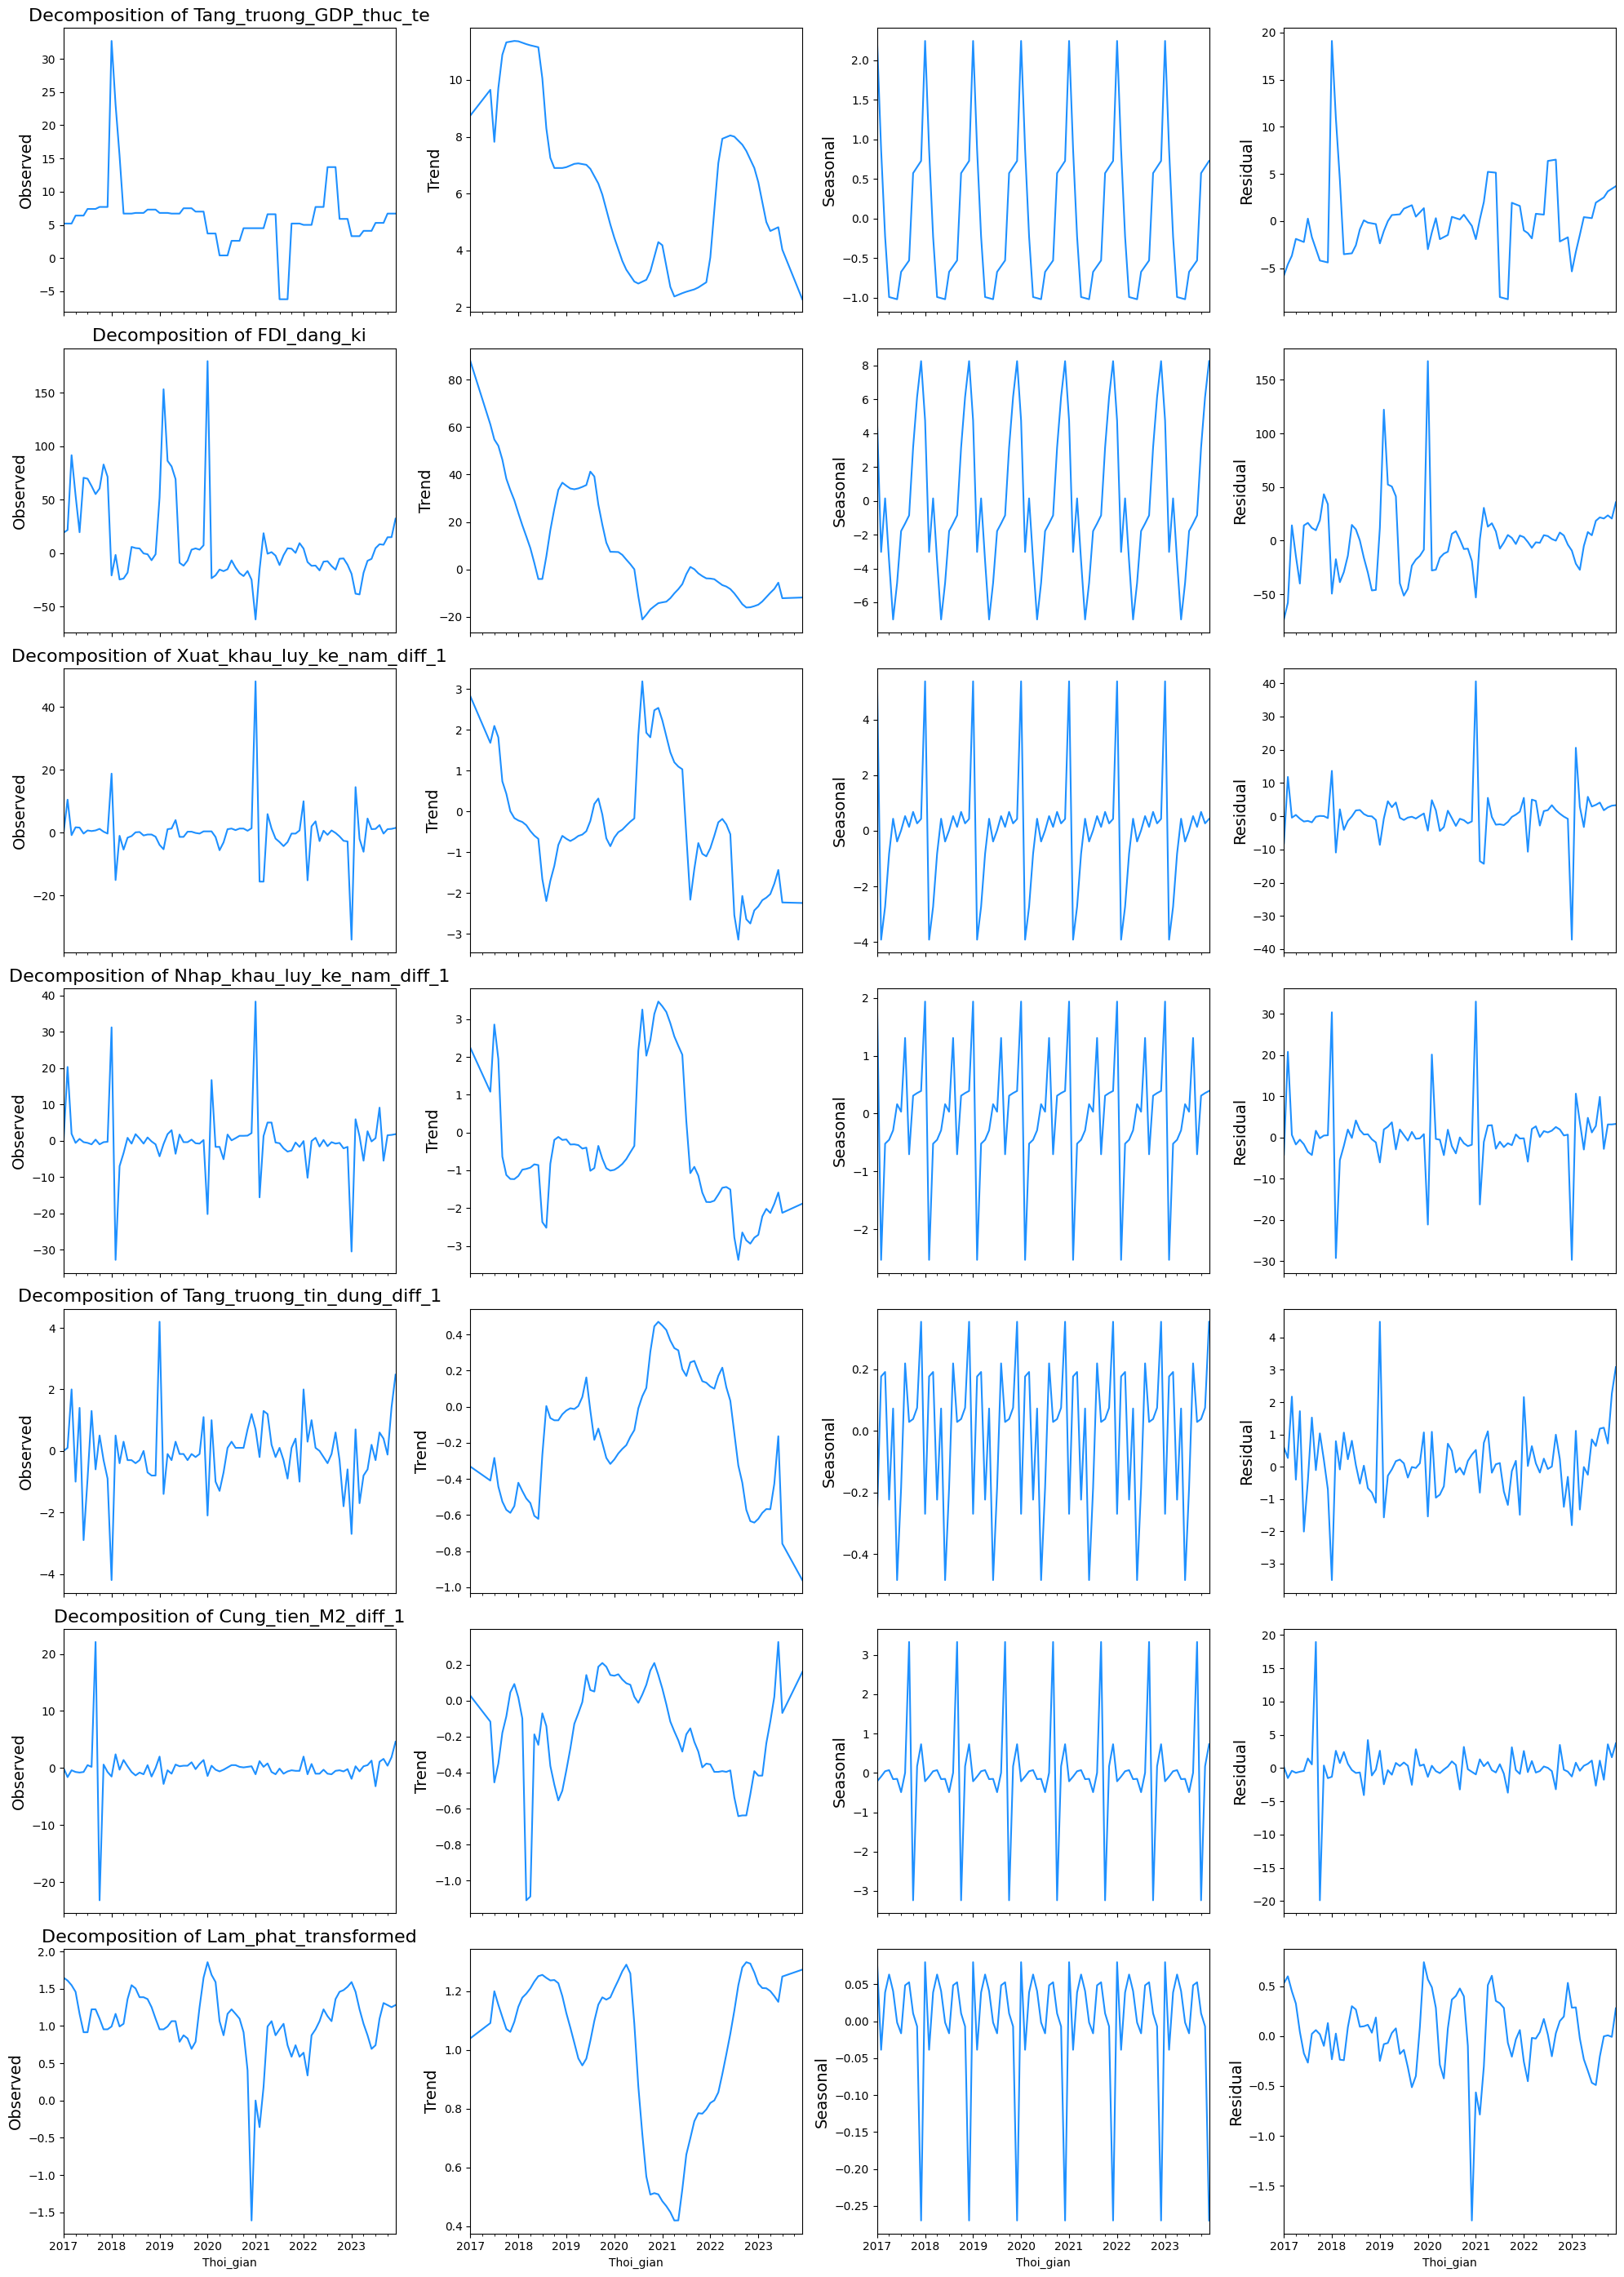

In [2075]:
num_rows = len(decompose_cols)
num_cols = 4  # Số cột gồm observed, trend, seasonal và residual

fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, sharex=True, figsize=(20, 4*num_rows))

for i, col in enumerate(decompose_cols):
    # Decomposition cho mỗi biến
    res = seasonal_decompose(data[col], period=12, model='additive', extrapolate_trend='freq')
    
    # Hiển thị observed
    ax[i, 0].set_title(f'Decomposition of {col}', fontsize=16)
    res.observed.plot(ax=ax[i, 0], legend=False, color='dodgerblue')
    ax[i, 0].set_ylabel('Observed', fontsize=14)

    # Hiển thị trend
    res.trend.plot(ax=ax[i, 1], legend=False, color='dodgerblue')
    ax[i, 1].set_ylabel('Trend', fontsize=14)

    # Hiển thị seasonal
    res.seasonal.plot(ax=ax[i, 2], legend=False, color='dodgerblue')
    ax[i, 2].set_ylabel('Seasonal', fontsize=14)

    # Hiển thị residual
    res.resid.plot(ax=ax[i, 3], legend=False, color='dodgerblue')
    ax[i, 3].set_ylabel('Residual', fontsize=14)

plt.tight_layout()
plt.show()

### 1.3.2. Time featuring

In [2076]:
data['year'] = pd.DatetimeIndex(data.index).year
data['month'] = pd.DatetimeIndex(data.index).month
data['quarter'] = pd.DatetimeIndex(data.index).quarter
data[['year', 'month', 'quarter']].tail()

,year,month,quarter
Thoi_gian,,,
2023-08-01,2023,8,3
2023-09-01,2023,9,3
2023-10-01,2023,10,4
2023-11-01,2023,11,4
2023-12-01,2023,12,4


## 1.4. EDA

### 1.4.1. Correlation Matrix

We can see that the correlation to the target variables increases if we use the time shifted features in comparison to the original features.

In [2077]:
data.columns

Index(['FDI_dang_ki', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam',
       'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat',
       'Tang_truong_GDP_thuc_te', 'Lam_phat_transformed',
       'Cung_tien_M2_diff_1', 'Cung_tien_M2_diff_2',
       'Nhap_khau_luy_ke_nam_diff_1', 'Nhap_khau_luy_ke_nam_diff_2',
       'Xuat_khau_luy_ke_nam_diff_1', 'Xuat_khau_luy_ke_nam_diff_2',
       'Tang_truong_tin_dung_diff_1', 'Tang_truong_tin_dung_diff_2',
       'Tang_truong_GDP_thuc_te_trend', 'Tang_truong_GDP_thuc_te_seasonal',
       'FDI_dang_ki_trend', 'FDI_dang_ki_seasonal',
       'Xuat_khau_luy_ke_nam_diff_1_trend',
       'Xuat_khau_luy_ke_nam_diff_1_seasonal',
       'Nhap_khau_luy_ke_nam_diff_1_trend',
       'Nhap_khau_luy_ke_nam_diff_1_seasonal',
       'Tang_truong_tin_dung_diff_1_trend',
       'Tang_truong_tin_dung_diff_1_seasonal', 'Cung_tien_M2_diff_1_trend',
       'Cung_tien_M2_diff_1_seasonal', 'Lam_phat_transformed_trend',
       'Lam_phat_transformed_seasonal', 'year', 'month

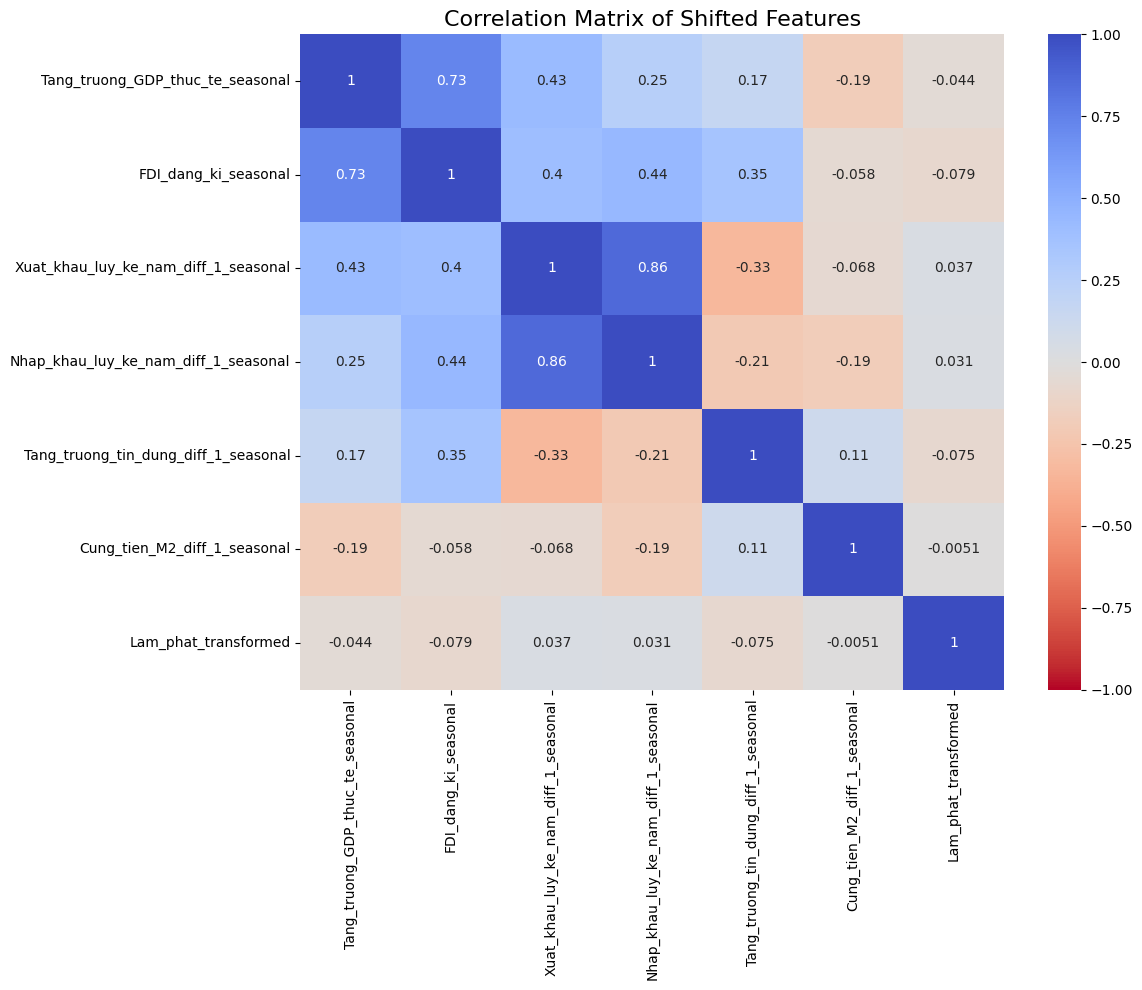

In [2078]:
plt.figure(figsize=(12,10))

shifted_cols = ['Tang_truong_GDP_thuc_te_seasonal', 'FDI_dang_ki_seasonal', 'Xuat_khau_luy_ke_nam_diff_1_seasonal', 'Nhap_khau_luy_ke_nam_diff_1_seasonal',
       'Tang_truong_tin_dung_diff_1_seasonal', 'Cung_tien_M2_diff_1_seasonal', 'Lam_phat_transformed']
corrmat = data[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r')
plt.title('Correlation Matrix of Shifted Features', fontsize=16)

plt.tight_layout()
plt.show()

##

### 1.4.2. Auto correlation

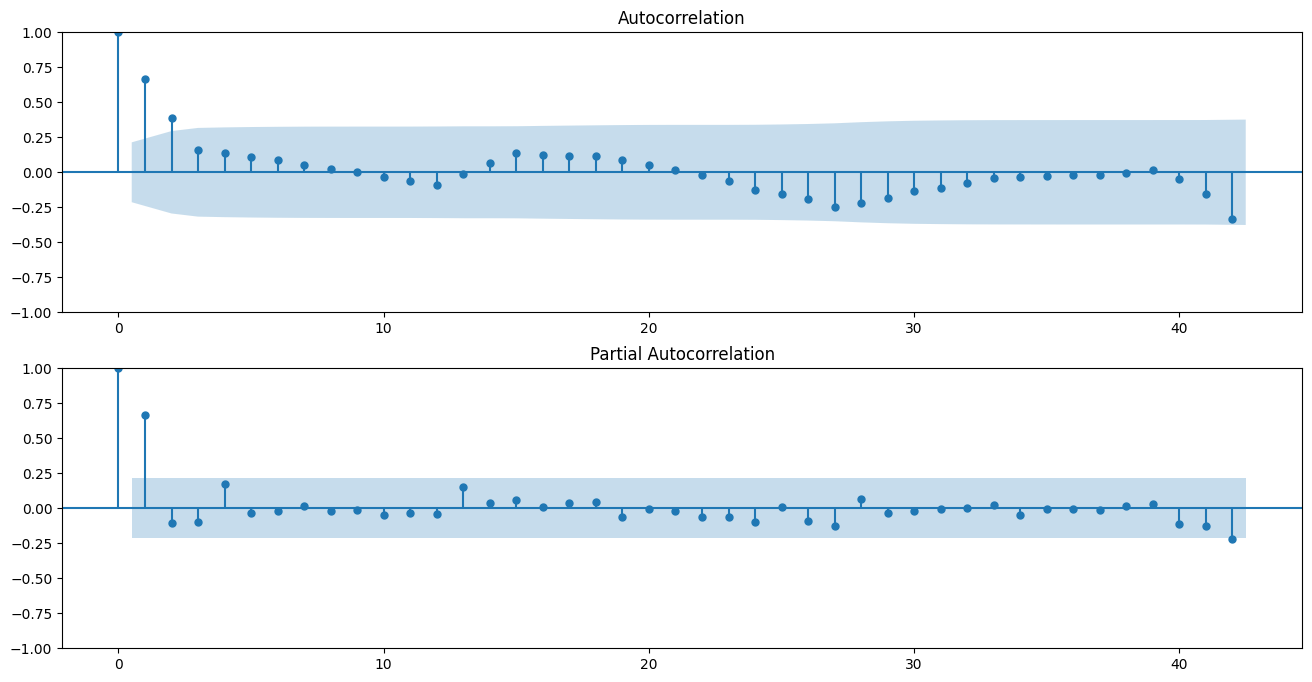

In [2079]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(data.Tang_truong_GDP_thuc_te,lags=42, ax=ax[0])
plot_pacf(data.Tang_truong_GDP_thuc_te,lags=42, ax=ax[1])
plt.show()

## 1.5. Cross validation

Thiết lập các bước cần thiết để chia dữ liệu chuỗi thời gian thành 3 phân đoạn không trùng lặp, giữ nguyên thứ tự thời gian. X chứa các chỉ số thời gian, còn y chứa dữ liệu mục tiêu là tốc độ tăng trưởng GDP thực tế. 

In [2080]:
N_SPLITS = 3

X = data.index
y = data.Tang_truong_GDP_thuc_te

folds = TimeSeriesSplit(n_splits=N_SPLITS)

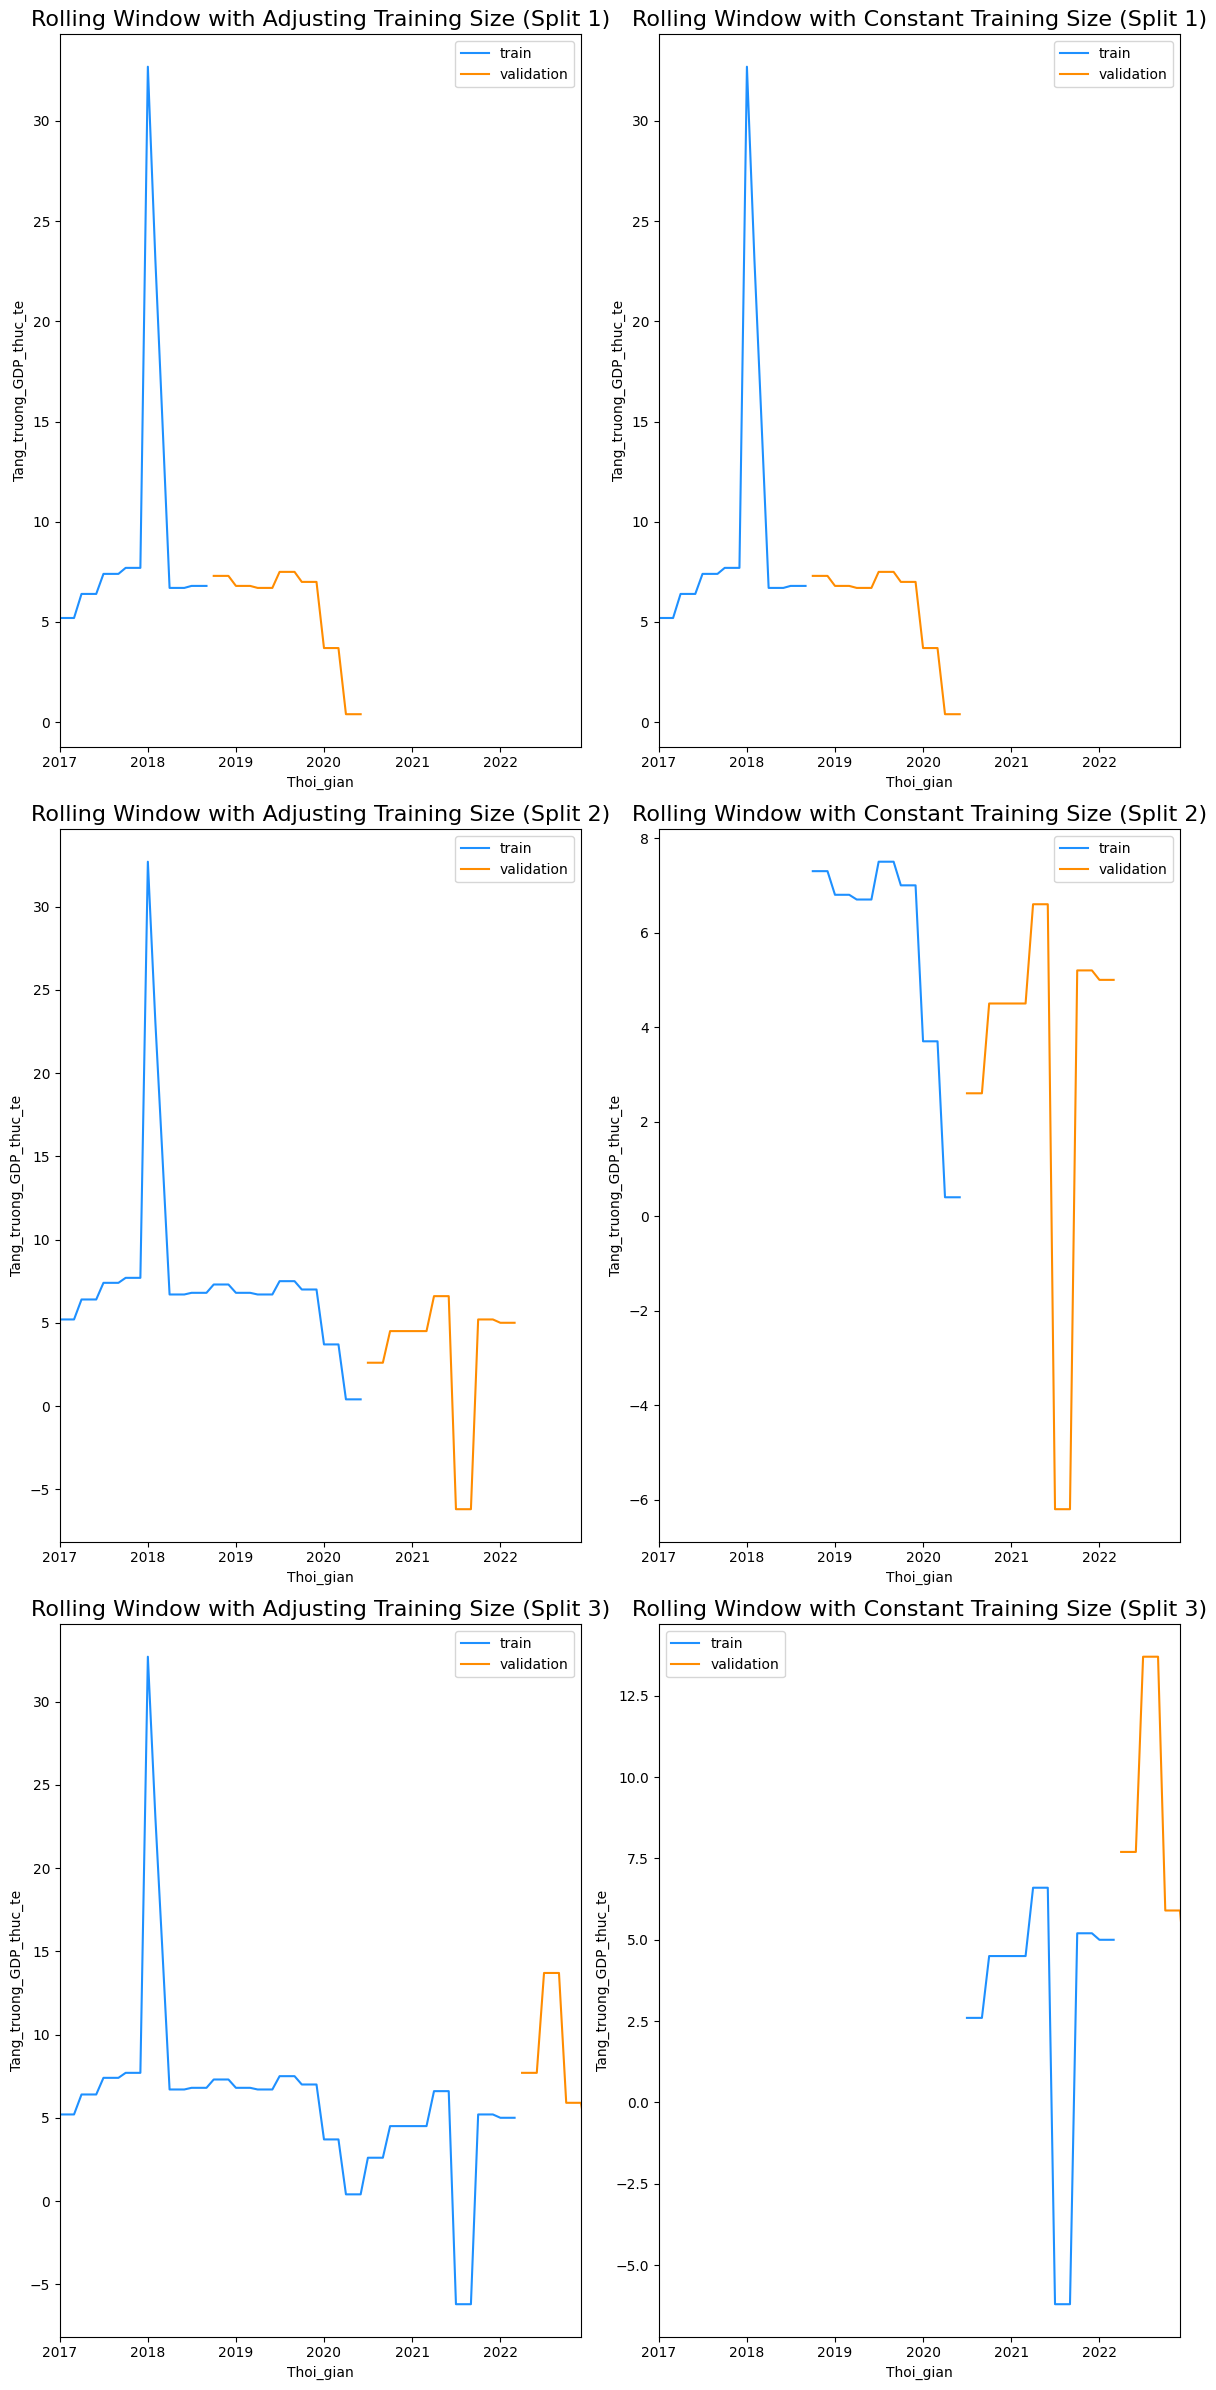

In [2081]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(6,12))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(x= X_train, y= y_train, ax=ax[i,0], color='dodgerblue', label='train')
    sns.lineplot(x= X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
                 y= y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
                 ax=ax[i,1], color='dodgerblue', label='train')

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2017, 1, 1), date(2022, 12, 1)])
    ax[i, 1].set_xlim([date(2017, 1, 1), date(2022, 12, 1)])
plt.tight_layout()
plt.show()

## 1.6. Model

In [2082]:
data['quarter_idx'] = (data.quarter != data.quarter.shift(1)).cumsum()

target = 'Tang_truong_GDP_thuc_te'
features = [feature for feature in data.columns if feature != target]

N_SPLITS = 24
# 2017 - 2022

X = data[data.quarter_idx < N_SPLITS][features]
y = data[data.quarter_idx < N_SPLITS][target]

X_test = data[data.quarter_idx == N_SPLITS][features]
y_test = data[data.quarter_idx == N_SPLITS][target]

In [2083]:
X.tail()

,FDI_dang_ki,Xuat_khau_luy_ke_nam,Nhap_khau_luy_ke_nam,Tang_truong_tin_dung,Cung_tien_M2,Lam_phat,Lam_phat_transformed,Cung_tien_M2_diff_1,Cung_tien_M2_diff_2,Nhap_khau_luy_ke_nam_diff_1,...,Tang_truong_tin_dung_diff_1_trend,Tang_truong_tin_dung_diff_1_seasonal,Cung_tien_M2_diff_1_trend,Cung_tien_M2_diff_1_seasonal,Lam_phat_transformed_trend,Lam_phat_transformed_seasonal,year,month,quarter,quarter_idx
Thoi_gian,,,,,,,,,,,,,,,,,,,,,
2022-05-01,-16.3,16.7,15.3,17.0,10.3,2.9,1.064711,-1.0,-1.0,-1.6,...,0.108333,0.073021,-0.395833,-0.158859,0.984421,0.040663,2022,5,2,22
2022-06-01,-8.1,17.3,15.5,16.8,10.0,3.4,1.223775,-0.3,-0.3,0.2,...,0.033333,-0.483695,-0.387500,-0.151181,1.054335,-0.001856,2022,6,2,22
2022-07-01,-7.7,16.6,14.0,16.4,9.0,3.1,1.131402,-1.0,-1.0,-1.5,...,-0.145833,-0.184457,-0.537500,-0.490171,1.132904,-0.016497,2022,7,3,23
2022-08-01,-12.2,17.3,13.6,16.3,7.9,2.9,1.064711,-1.1,-1.1,-0.4,...,-0.325000,0.219516,-0.641667,0.003333,1.219134,0.048456,2022,8,3,23
2022-09-01,-15.6,17.2,12.8,16.9,7.4,3.9,1.360977,-0.5,-0.5,-0.8,...,-0.420833,0.029442,-0.637500,3.329576,1.280403,0.052610,2022,9,3,23


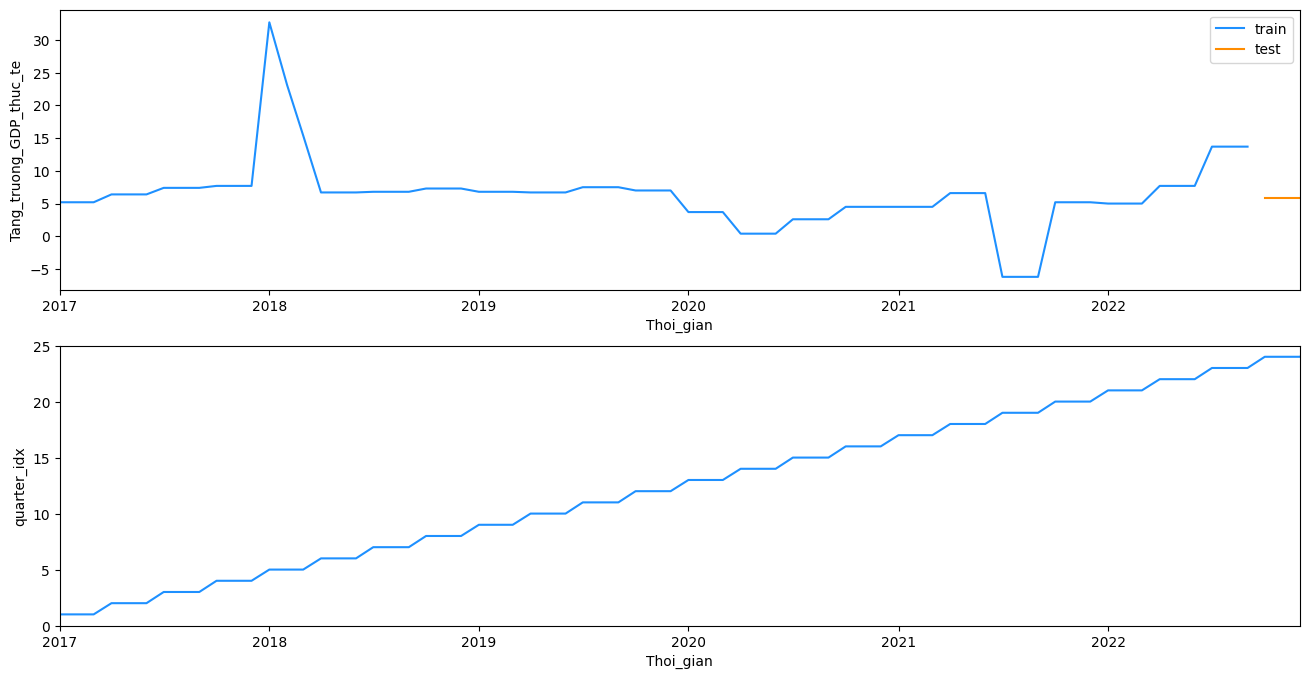

In [2084]:
folds = np.linspace(0, N_SPLITS-3, num=N_SPLITS-2)

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

sns.lineplot(x=X.index, y=y, ax=ax[0], color='dodgerblue', label='train')
sns.lineplot(x=X_test.index, y=y_test, ax=ax[0], color='darkorange', label='test')

sns.lineplot(x=data.index, y=data.quarter_idx, ax=ax[1], color='dodgerblue')
ax[0].set_xlim([date(2017, 1, 1), date(2022, 12, 1)])
ax[1].set_xlim([date(2017, 1, 1), date(2022, 12, 1)])
ax[1].set_ylim([0, N_SPLITS+1])

plt.show()

In [2085]:
def plot_approach_evaluation(y_pred, y_valid_pred, score_mae, score_rsme, approach_name):
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    f.suptitle(approach_name, fontsize=16)
    sns.lineplot(x=X.index, y=y, ax=ax[0], color='dodgerblue', label='Training', linewidth=2)
    sns.lineplot(x=X_test.index, y=y_test, ax=ax[0], color='gold', label='Ground Truth', linewidth=2) #navajowhite
    sns.lineplot(x=X_test.index, y=y_pred, ax=ax[0], color='darkorange', label='Predicted', linewidth=2)
    ax[0].set_xlim([date(2017, 1, 1), date(2022, 12, 1)])
    ax[0].set_ylim([-30, 30])
    ax[0].set_title(f'Prediction \n MAE: {mean_absolute_error(y_test, y_pred):.2f}, RSME: {math.sqrt(mean_squared_error(y_valid, y_valid_pred)):.2f}', fontsize=14)
    ax[0].set_xlabel(xlabel='Date', fontsize=14)
    ax[0].set_ylabel(ylabel='Tang truong GDP thuc te', fontsize=14)

    sns.lineplot(x=folds, y=score_mae,  color='gold', label='MAE', ax=ax[1])
    sns.lineplot(x=folds, y=score_rsme, color='indianred', label='RSME', ax=ax[1])
    ax[1].set_title('Loss', fontsize=14)
    ax[1].set_xlabel(xlabel='Fold', fontsize=14)
    ax[1].set_ylabel(ylabel='Loss', fontsize=14)
    ax[1].set_ylim([0, 30])   
    plt.show()

In [2086]:
# score_mae = []
# score_rmse = []

# # Ensure quarter_idx and valid_quarter_id are consistent
# for fold, valid_quarter_id in enumerate(range(2, N_SPLITS)):
#     # Get indices for this fold
#     train_index = data[data.quarter_idx < valid_quarter_id].index
#     valid_index = data[data.quarter_idx == valid_quarter_id].index

#     # Ensure valid indices
#     if len(train_index) == 0 or len(valid_index) == 0:
#         print(f"Skipping fold {fold} due to empty train or valid index.")
#         continue

#     # Convert indices to iloc positions
#     train_iloc = [data.index.get_loc(idx) for idx in train_index]
#     valid_iloc = [data.index.get_loc(idx) for idx in valid_index]

#     # Prepare training and validation data for this fold
#     y_train, y_valid = y.iloc[train_iloc], y.iloc[valid_iloc]
    
#     # Initialize y_valid_pred
#     y_valid_pred = pd.Series(np.ones(len(y_valid)))
    
#     # Prediction: Naive approach
#     y_valid_pred = y_valid_pred * y_train.iloc[-1]
    
#     # Calculate metrics
#     score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
#     score_rmse.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

# # Check final train and test data
# print(f"Final train data length: {len(X)}, test data length: {len(X_test)}")

# y_pred = pd.Series(np.ones(len(X_test))) * y.iloc[-1]

# plot_approach_evaluation(y_pred, y_valid_pred, score_mae, score_rmse, 'Naive Approach')

2022-10-01 00:00:00
2022-12-01 00:00:00


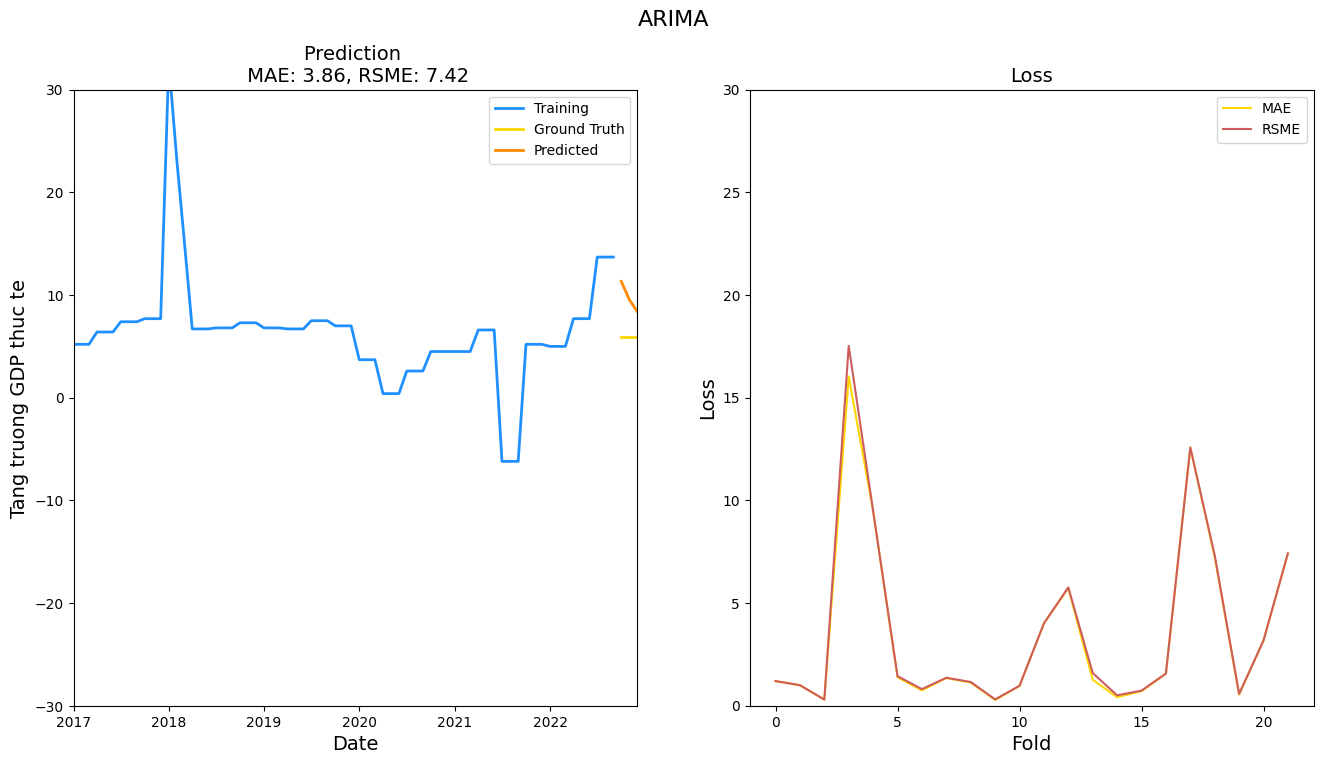

In [2087]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

score_mae = []
score_rmse = []

for fold, valid_quarter_id in enumerate(range(2, N_SPLITS)):
    # Get indices for this fold
    train_index = data[data.quarter_idx < valid_quarter_id].index
    valid_index = data[data.quarter_idx == valid_quarter_id].index

    # Convert indices to iloc positions
    train_iloc = [data.index.get_loc(idx) for idx in train_index]
    valid_iloc = [data.index.get_loc(idx) for idx in valid_index]

    # Prepare training and validation data for this fold
    y_train, y_valid = y.iloc[train_iloc], y.iloc[valid_iloc]
    
    # Fit ARIMA model
    model = ARIMA(y_train, order=(1, 1, 1))
    model_fit = model.fit()
    
    # Prediction with ARIMA
    y_valid_pred = model_fit.predict(start=valid_index[0], end=valid_index[-1])
    
    # Calculate metrics
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rmse.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

# Fit ARIMA model on the entire dataset
model = ARIMA(y, order=(2, 1, 1))
model_fit = model.fit()

# Calculate the prediction range
start_index = y.index[-1] + pd.DateOffset(months=1)
end_index = start_index + pd.DateOffset(months=len(y_test) - 1)
print(start_index)
print(end_index)

# Predict future values
y_pred = model_fit.predict(start=start_index, end=end_index).reset_index(drop=True)

# Plot and evaluate
plot_approach_evaluation(y_pred, y_valid_pred, score_mae, score_rmse, 'ARIMA')


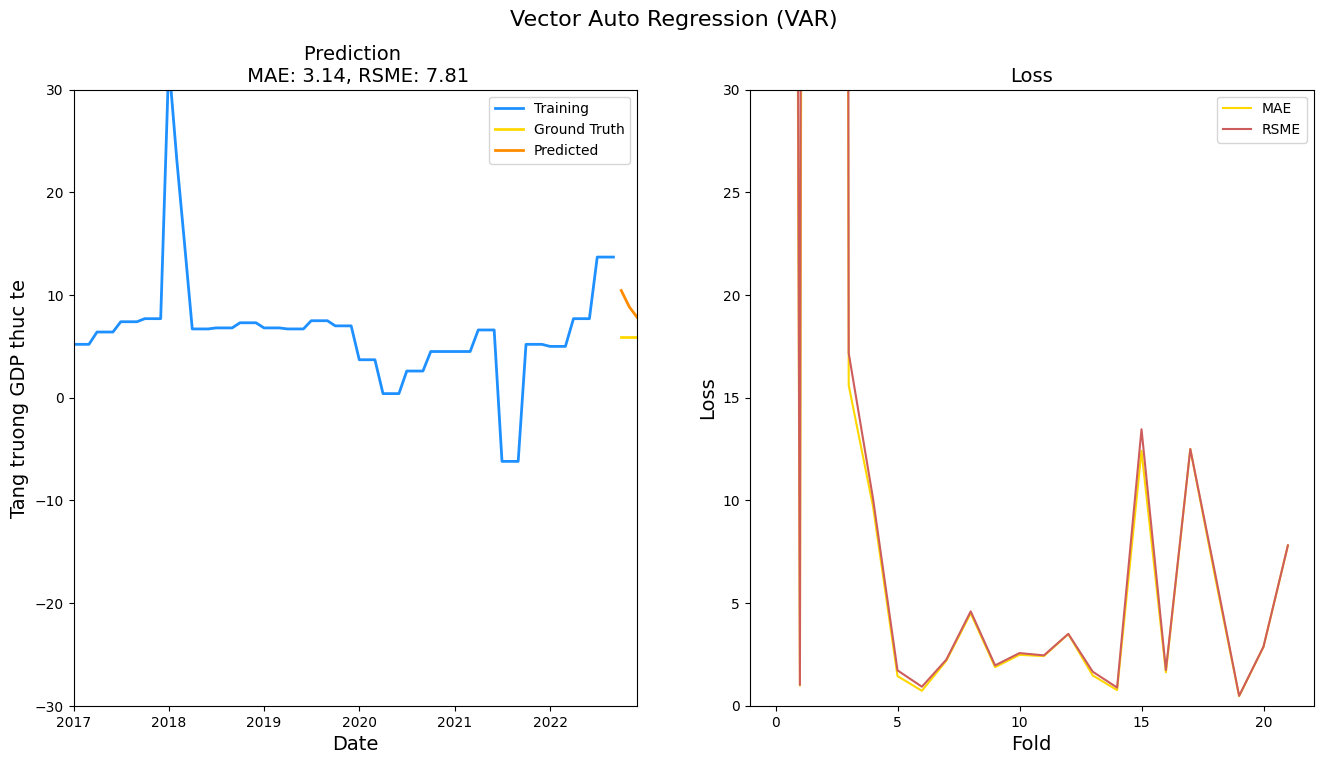

In [2088]:
score_mae = []
score_rsme = []

features = ['FDI_dang_ki', 'Xuat_khau_luy_ke_nam_diff_1', 'Nhap_khau_luy_ke_nam_diff_1',
       'Tang_truong_tin_dung_diff_1', 'Cung_tien_M2_diff_1', 'Lam_phat_transformed']

def remove_constant_columns(df):
    """Remove constant columns from the dataframe."""
    return df.loc[:, (df != df.iloc[0]).any()]

for fold, valid_quarter_id in enumerate(range(2, N_SPLITS)):
    # Get indices for this fold
    train_index = data[data.quarter_idx < valid_quarter_id].index
    valid_index = data[data.quarter_idx == valid_quarter_id].index
    # Convert indices to iloc positions
    train_iloc = [data.index.get_loc(idx) for idx in train_index]
    valid_iloc = [data.index.get_loc(idx) for idx in valid_index]

    # Prepare training and validation data for this fold
    X_train, X_valid = X.iloc[train_iloc][features], X.iloc[valid_iloc][features]
    y_train, y_valid = y.iloc[train_iloc], y.iloc[valid_iloc]
    
    # Combine y_train and X_train
    train_data = pd.concat([y_train, X_train], axis=1)
    
    # Remove constant columns from train_data
    train_data = remove_constant_columns(train_data)

    # Fit model with Vector Auto Regression (VAR)
    model = VAR(train_data)
    model_fit = model.fit()

    # Prepare validation data for prediction
    valid_data = pd.concat([y_valid, X_valid], axis=1)
    valid_data = remove_constant_columns(valid_data)
    
    # Prediction with Vector Auto Regression (VAR)
    lag_order = model_fit.k_ar
    forecast_input = train_data.values[-lag_order:]
    y_valid_pred = model_fit.forecast(y=forecast_input, steps=len(X_valid))
    y_valid_pred = pd.Series(y_valid_pred[:, 0])

    # Calculate metrics
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

# Combine y and X for the final model
final_data = pd.concat([y, X[features]], axis=1)
final_data = remove_constant_columns(final_data)

# Fit final model with Vector Auto Regression (VAR)
model = VAR(final_data)
model_fit = model.fit()

# Prediction with Vector Auto Regression (VAR)
lag_order = model_fit.k_ar
forecast_input = final_data.values[-lag_order:]
y_pred = model_fit.forecast(y=forecast_input, steps=len(X_valid))
y_pred = pd.Series(y_pred[:, 0])

plot_approach_evaluation(y_pred, y_valid_pred, score_mae, score_rsme, 'Vector Auto Regression (VAR)')